# Importaciones 

In [1]:
# Celda 1: imports básicos y configuración de ruta

import os
import sys
import math
from itertools import cycle

import torch
from torch import nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import LambdaLR
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

# Ir a la carpeta raíz del proyecto (donde está pc3_main.py)
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
os.chdir(project_root)
print("Working dir:", os.getcwd())

# Asegurar que src/ esté en el path
if project_root not in sys.path:
    sys.path.append(project_root)

from src.utils import (
    load_config,
    set_seed,
    get_device,
    count_parameters,
    save_checkpoint,
)
from src.data import create_dataloaders
from src.models.transformer import MicroTransformer


Working dir: c:\Users\USER\Documents\GitHub\Procesamiento_lenguaje_natural\PC3


# Funciones 

## configuracion basica

In [2]:
# Celda 2: cargar config base, fijar seed y crear dataloaders (solo una vez)

CONFIG_PATH = "configs/train.yaml"
BASE_CFG = load_config(CONFIG_PATH)

# Puedes ajustar el número de pasos "por defecto" para estos experimentos cortos
BASE_CFG["train"]["num_steps"] = 1000      # por ejemplo
BASE_CFG["train"]["eval_every"] = 200
BASE_CFG["train"]["batch_size"] = 32

print("Config base cargada.")
print("num_steps base:", BASE_CFG["train"]["num_steps"])

# Fijar seed y device
set_seed(BASE_CFG["train"].get("seed", 42))
device = get_device(BASE_CFG["train"].get("device", "cuda"))
print("Device:", device)

# DataLoaders y tokenizer (son compartidos entre los 3 experimentos)
train_loader, val_loader, tokenizer = create_dataloaders(BASE_CFG)
vocab_size = tokenizer.vocab_size

print("Vocab_size:", vocab_size)
print("Batches train:", len(train_loader))
print("Batches val:", len(val_loader))



[2025-11-21 04:34:15,572] INFO - Seed fijada a 42
[2025-11-21 04:34:15,603] INFO - Texto cargado desde data\raw\input.txt (longitud 1115394 caracteres).
[2025-11-21 04:34:15,604] INFO - Vocabulario cargado con 65 caracteres.
[2025-11-21 04:34:15,707] INFO - Split datos: train=1104241, val=11153


Config base cargada.
num_steps base: 1000
Device: cuda
Vocab_size: 65
Batches train: 34499
Batches val: 340


# Helpers

In [3]:
# Celda 3: funciones helper (scheduler y evaluación)

def build_scheduler(optimizer, num_steps: int, warmup_steps: int):
    def lr_lambda(step: int):
        if step < warmup_steps:
            return float(step + 1) / float(max(1, warmup_steps))
        return max(0.0, float(num_steps - step) / float(max(1, num_steps - warmup_steps)))
    return LambdaLR(optimizer, lr_lambda)


@torch.no_grad()
def evaluate(model, data_loader, device, criterion):
    model.eval()
    total_loss = 0.0
    total_tokens = 0

    for x, y in data_loader:
        x = x.to(device)
        y = y.to(device)

        logits = model(x)
        loss = criterion(
            logits.view(-1, logits.size(-1)),
            y.view(-1),
        )

        total_loss += loss.item() * y.numel()
        total_tokens += y.numel()

    avg_loss = total_loss / max(1, total_tokens)
    return avg_loss


In [4]:

config_path = "configs/train.yaml"
cfg = load_config(config_path)


cfg["train"]["num_steps"] = 1000      
cfg["train"]["eval_every"] = 200
cfg["train"]["batch_size"] = 32


cfg["model"]["posenc_type"] = "rope"

print("Config cargada.")
print("posenc_type:", cfg["model"]["posenc_type"])
print("num_steps:", cfg["train"]["num_steps"])

set_seed(cfg["train"].get("seed", 42))
device = get_device(cfg["train"].get("device", "cuda"))
device




def run_experiment(
    posenc_type: str,
    num_steps: int = None,
    eval_every: int = None,
    checkpoint_name: str = None,
):

    import json

    os.makedirs("checkpoints", exist_ok=True)
    os.makedirs("outputs", exist_ok=True)

    tag = posenc_type.lower()
    ckpt_path = checkpoint_name or f"checkpoints/best_{tag}.pt"
    train_curve_path = f"outputs/train_curve_{tag}.csv"
    val_curve_path = f"outputs/val_curve_{tag}.csv"
    metrics_path = f"outputs/metrics_{tag}.json"

    
    if os.path.exists(ckpt_path) and os.path.exists(metrics_path):
        print(f"[{posenc_type}] Checkpoint y métricas ya existen. Cargando métricas...")
        with open(metrics_path, "r", encoding="utf-8") as f:
            metrics = json.load(f)
        display(pd.DataFrame([metrics]))
        return metrics


    cfg = json.loads(json.dumps(BASE_CFG)) 
    train_cfg = cfg["train"]

    if num_steps is not None:
        train_cfg["num_steps"] = int(num_steps)
    if eval_every is not None:
        train_cfg["eval_every"] = int(eval_every)

    train_cfg_num_steps = int(train_cfg["num_steps"])
    train_cfg_eval_every = int(train_cfg.get("eval_every", 200))

    cfg["model"]["posenc_type"] = posenc_type
    model_cfg = cfg["model"]


    model = MicroTransformer(
        vocab_size=vocab_size,
        d_model=model_cfg["d_model"],
        n_heads=model_cfg["n_heads"],
        n_layers=model_cfg["n_layers"],
        d_ff=model_cfg["d_ff"],
        dropout=model_cfg.get("dropout", 0.1),
        max_seq_len=model_cfg["max_seq_len"],
        posenc_type=model_cfg.get("posenc_type", "rope"),
    ).to(device)

    print(f"\n[{posenc_type}] Modelo con {count_parameters(model):,} parámetros")
    print(f"[{posenc_type}] Device del modelo:", next(model.parameters()).device)

    lr = float(train_cfg["lr"])
    warmup_steps = int(train_cfg.get("warmup_steps", 0))
    grad_clip = float(train_cfg.get("grad_clip", 1.0))

    optimizer = AdamW(
        model.parameters(),
        lr=lr,
        weight_decay=float(train_cfg.get("weight_decay", 0.0)),
    )
    scheduler = build_scheduler(optimizer, train_cfg_num_steps, warmup_steps)
    criterion = nn.CrossEntropyLoss()


    train_losses = []
    val_losses = []
    steps_hist = []

    step = 0
    train_iter = cycle(train_loader)

    pbar = tqdm(range(train_cfg_num_steps), desc=f"Entrenando ({posenc_type})")

    best_val_loss = float("inf")

    while step < train_cfg_num_steps:
        model.train()
        x, y = next(train_iter)
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = criterion(
            logits.view(-1, logits.size(-1)),
            y.view(-1),
        )
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()
        scheduler.step()

        step += 1
        train_losses.append(loss.item())
        steps_hist.append(step)
        pbar.set_postfix(loss=loss.item())

        # evaluación periódica
        if (step % train_cfg_eval_every == 0) or (step == train_cfg_num_steps):
            val_loss = evaluate(model, val_loader, device, criterion)
            val_losses.append((step, val_loss))
            print(f"\n[{posenc_type}][VAL] step={step}/{train_cfg_num_steps} "
                  f"loss={val_loss:.4f} ppl={math.exp(val_loss):.2f}")

            # Guardar mejor modelo
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                save_checkpoint(
                    ckpt_path,
                    model,
                    optimizer,
                    scheduler,
                    step=step,
                    extra={"val_loss": val_loss, "posenc_type": posenc_type},
                )
                print(f"[{posenc_type}] Nuevo mejor checkpoint guardado en {ckpt_path}")

    pbar.close()
    print(f"[{posenc_type}] Entrenamiento finalizado.")

    
    df_train = pd.DataFrame({"step": steps_hist, "train_loss": train_losses})
    df_train.to_csv(train_curve_path, index=False)

    df_val = pd.DataFrame({
        "step": [s for s, _ in val_losses],
        "val_loss": [l for _, l in val_losses],
    })
    df_val.to_csv(val_curve_path, index=False)

   
    final_train_loss = float(train_losses[-1])
    last_val_step, last_val_loss = val_losses[-1]
    metrics = {
        "posenc_type": posenc_type,
        "num_steps": train_cfg_num_steps,
        "eval_every": train_cfg_eval_every,
        "final_train_loss": final_train_loss,
        "val_loss": float(last_val_loss),
        "val_ppl": float(math.exp(last_val_loss)),
        "checkpoint": ckpt_path,
        "train_curve": train_curve_path,
        "val_curve": val_curve_path,
    }

    with open(metrics_path, "w", encoding="utf-8") as f:
        json.dump(metrics, f, ensure_ascii=False, indent=2)

    display(pd.DataFrame([metrics]))
    return metrics


Config cargada.
posenc_type: rope
num_steps: 1000


[2025-11-21 04:34:15,752] INFO - Seed fijada a 42


# Ejecuciones 

## Para sinusoidal 

In [5]:
metrics_sin = run_experiment(
    posenc_type="sinusoidal",
    num_steps=1000,      
    eval_every=100,
)
metrics_sin


c:\Users\USER\anaconda3\envs\nlp\lib\site-packages\torch\cuda\__init__.py:235: UserWarning: 
NVIDIA GeForce RTX 5070 with CUDA capability sm_120 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_50 sm_60 sm_61 sm_70 sm_75 sm_80 sm_86 sm_90 sm_37 compute_37.
If you want to use the NVIDIA GeForce RTX 5070 GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(



[sinusoidal] Modelo con 3,192,832 parámetros
[sinusoidal] Device del modelo: cuda:0


Entrenando (sinusoidal):   0%|          | 0/1000 [00:09<?, ?it/s, loss=2.55]


[sinusoidal][VAL] step=100/1000 loss=2.6014 ppl=13.48
[sinusoidal] Nuevo mejor checkpoint guardado en checkpoints/best_sinusoidal.pt


Entrenando (sinusoidal):   0%|          | 0/1000 [00:18<?, ?it/s, loss=2.5] 


[sinusoidal][VAL] step=200/1000 loss=2.5180 ppl=12.40
[sinusoidal] Nuevo mejor checkpoint guardado en checkpoints/best_sinusoidal.pt


Entrenando (sinusoidal):   0%|          | 0/1000 [00:27<?, ?it/s, loss=2.39]


[sinusoidal][VAL] step=300/1000 loss=2.4358 ppl=11.43
[sinusoidal] Nuevo mejor checkpoint guardado en checkpoints/best_sinusoidal.pt


Entrenando (sinusoidal):   0%|          | 0/1000 [00:36<?, ?it/s, loss=2.32]


[sinusoidal][VAL] step=400/1000 loss=2.3515 ppl=10.50
[sinusoidal] Nuevo mejor checkpoint guardado en checkpoints/best_sinusoidal.pt


Entrenando (sinusoidal):   0%|          | 0/1000 [00:46<?, ?it/s, loss=2.27]


[sinusoidal][VAL] step=500/1000 loss=2.2880 ppl=9.86
[sinusoidal] Nuevo mejor checkpoint guardado en checkpoints/best_sinusoidal.pt


Entrenando (sinusoidal):   0%|          | 0/1000 [00:55<?, ?it/s, loss=2.24]


[sinusoidal][VAL] step=600/1000 loss=2.2399 ppl=9.39
[sinusoidal] Nuevo mejor checkpoint guardado en checkpoints/best_sinusoidal.pt


Entrenando (sinusoidal):   0%|          | 0/1000 [01:04<?, ?it/s, loss=2.19]


[sinusoidal][VAL] step=700/1000 loss=2.2189 ppl=9.20
[sinusoidal] Nuevo mejor checkpoint guardado en checkpoints/best_sinusoidal.pt


Entrenando (sinusoidal):   0%|          | 0/1000 [01:13<?, ?it/s, loss=2.14]


[sinusoidal][VAL] step=800/1000 loss=2.1963 ppl=8.99
[sinusoidal] Nuevo mejor checkpoint guardado en checkpoints/best_sinusoidal.pt


Entrenando (sinusoidal):   0%|          | 0/1000 [01:22<?, ?it/s, loss=2.17]


[sinusoidal][VAL] step=900/1000 loss=2.1793 ppl=8.84
[sinusoidal] Nuevo mejor checkpoint guardado en checkpoints/best_sinusoidal.pt


Entrenando (sinusoidal):   0%|          | 0/1000 [01:31<?, ?it/s, loss=2.13]


[sinusoidal][VAL] step=1000/1000 loss=2.1790 ppl=8.84
[sinusoidal] Nuevo mejor checkpoint guardado en checkpoints/best_sinusoidal.pt
[sinusoidal] Entrenamiento finalizado.


,posenc_type,num_steps,eval_every,final_train_loss,val_loss,val_ppl,checkpoint,train_curve,val_curve
0,sinusoidal,1000,100,2.132046,2.178952,8.837038,checkpoints/best_sinusoidal.pt,outputs/train_curve_sinusoidal.csv,outputs/val_curve_sinusoidal.csv


{'posenc_type': 'sinusoidal',
 'num_steps': 1000,
 'eval_every': 100,
 'final_train_loss': 2.1320459842681885,
 'val_loss': 2.178951723435346,
 'val_ppl': 8.837037742019287,
 'checkpoint': 'checkpoints/best_sinusoidal.pt',
 'train_curve': 'outputs/train_curve_sinusoidal.csv',
 'val_curve': 'outputs/val_curve_sinusoidal.csv'}

## Para RoPE


In [6]:

metrics_rope = run_experiment(
    posenc_type="rope",
    num_steps=1000,    
    eval_every=100,
)
metrics_rope



[rope] Modelo con 3,192,832 parámetros
[rope] Device del modelo: cuda:0


Entrenando (rope):   0%|          | 0/1000 [00:10<?, ?it/s, loss=2.44]


[rope][VAL] step=100/1000 loss=2.4881 ppl=12.04
[rope] Nuevo mejor checkpoint guardado en checkpoints/best_rope.pt


Entrenando (rope):   0%|          | 0/1000 [00:19<?, ?it/s, loss=2.12]


[rope][VAL] step=200/1000 loss=2.1607 ppl=8.68
[rope] Nuevo mejor checkpoint guardado en checkpoints/best_rope.pt


Entrenando (rope):   0%|          | 0/1000 [00:29<?, ?it/s, loss=1.97]


[rope][VAL] step=300/1000 loss=2.0432 ppl=7.72
[rope] Nuevo mejor checkpoint guardado en checkpoints/best_rope.pt


Entrenando (rope):   0%|          | 0/1000 [00:39<?, ?it/s, loss=1.91]


[rope][VAL] step=400/1000 loss=1.9637 ppl=7.13
[rope] Nuevo mejor checkpoint guardado en checkpoints/best_rope.pt


Entrenando (rope):   0%|          | 0/1000 [00:49<?, ?it/s, loss=1.85]


[rope][VAL] step=500/1000 loss=1.9363 ppl=6.93
[rope] Nuevo mejor checkpoint guardado en checkpoints/best_rope.pt


Entrenando (rope):   0%|          | 0/1000 [00:59<?, ?it/s, loss=1.81]


[rope][VAL] step=600/1000 loss=1.9039 ppl=6.71
[rope] Nuevo mejor checkpoint guardado en checkpoints/best_rope.pt


Entrenando (rope):   0%|          | 0/1000 [01:09<?, ?it/s, loss=1.79]


[rope][VAL] step=700/1000 loss=1.8807 ppl=6.56
[rope] Nuevo mejor checkpoint guardado en checkpoints/best_rope.pt


Entrenando (rope):   0%|          | 0/1000 [01:19<?, ?it/s, loss=1.78]


[rope][VAL] step=800/1000 loss=1.8663 ppl=6.46
[rope] Nuevo mejor checkpoint guardado en checkpoints/best_rope.pt


Entrenando (rope):   0%|          | 0/1000 [01:29<?, ?it/s, loss=1.74]


[rope][VAL] step=900/1000 loss=1.8624 ppl=6.44
[rope] Nuevo mejor checkpoint guardado en checkpoints/best_rope.pt


Entrenando (rope):   0%|          | 0/1000 [01:38<?, ?it/s, loss=1.76]


[rope][VAL] step=1000/1000 loss=1.8565 ppl=6.40
[rope] Nuevo mejor checkpoint guardado en checkpoints/best_rope.pt
[rope] Entrenamiento finalizado.


,posenc_type,num_steps,eval_every,final_train_loss,val_loss,val_ppl,checkpoint,train_curve,val_curve
0,rope,1000,100,1.756521,1.856481,6.401173,checkpoints/best_rope.pt,outputs/train_curve_rope.csv,outputs/val_curve_rope.csv


{'posenc_type': 'rope',
 'num_steps': 1000,
 'eval_every': 100,
 'final_train_loss': 1.7565213441848755,
 'val_loss': 1.8564812425304862,
 'val_ppl': 6.401172921322008,
 'checkpoint': 'checkpoints/best_rope.pt',
 'train_curve': 'outputs/train_curve_rope.csv',
 'val_curve': 'outputs/val_curve_rope.csv'}

## Para ALiBi

In [7]:

metrics_alibi = run_experiment(
    posenc_type="alibi",
    num_steps=1000,
    eval_every=100,
)
metrics_alibi



[alibi] Modelo con 3,192,832 parámetros
[alibi] Device del modelo: cuda:0


Entrenando (alibi):   0%|          | 0/1000 [00:09<?, ?it/s, loss=2.52]


[alibi][VAL] step=100/1000 loss=2.5910 ppl=13.34
[alibi] Nuevo mejor checkpoint guardado en checkpoints/best_alibi.pt


Entrenando (alibi):   0%|          | 0/1000 [00:18<?, ?it/s, loss=2.48]


[alibi][VAL] step=200/1000 loss=2.5243 ppl=12.48
[alibi] Nuevo mejor checkpoint guardado en checkpoints/best_alibi.pt


Entrenando (alibi):   0%|          | 0/1000 [00:28<?, ?it/s, loss=2.44]


[alibi][VAL] step=300/1000 loss=2.5293 ppl=12.54


Entrenando (alibi):   0%|          | 0/1000 [00:37<?, ?it/s, loss=2.48]


[alibi][VAL] step=400/1000 loss=2.5225 ppl=12.46
[alibi] Nuevo mejor checkpoint guardado en checkpoints/best_alibi.pt


Entrenando (alibi):   0%|          | 0/1000 [00:47<?, ?it/s, loss=2.44]


[alibi][VAL] step=500/1000 loss=2.4996 ppl=12.18
[alibi] Nuevo mejor checkpoint guardado en checkpoints/best_alibi.pt


Entrenando (alibi):   0%|          | 0/1000 [00:56<?, ?it/s, loss=2.41]


[alibi][VAL] step=600/1000 loss=2.5104 ppl=12.31


Entrenando (alibi):   0%|          | 0/1000 [01:06<?, ?it/s, loss=2.42]


[alibi][VAL] step=700/1000 loss=2.4995 ppl=12.18
[alibi] Nuevo mejor checkpoint guardado en checkpoints/best_alibi.pt


Entrenando (alibi):   0%|          | 0/1000 [01:15<?, ?it/s, loss=2.42]


[alibi][VAL] step=800/1000 loss=2.4967 ppl=12.14
[alibi] Nuevo mejor checkpoint guardado en checkpoints/best_alibi.pt


Entrenando (alibi):   0%|          | 0/1000 [01:25<?, ?it/s, loss=2.43]


[alibi][VAL] step=900/1000 loss=2.4925 ppl=12.09
[alibi] Nuevo mejor checkpoint guardado en checkpoints/best_alibi.pt


Entrenando (alibi):   0%|          | 0/1000 [01:34<?, ?it/s, loss=2.39]


[alibi][VAL] step=1000/1000 loss=2.4890 ppl=12.05
[alibi] Nuevo mejor checkpoint guardado en checkpoints/best_alibi.pt
[alibi] Entrenamiento finalizado.


,posenc_type,num_steps,eval_every,final_train_loss,val_loss,val_ppl,checkpoint,train_curve,val_curve
0,alibi,1000,100,2.392014,2.489011,12.049358,checkpoints/best_alibi.pt,outputs/train_curve_alibi.csv,outputs/val_curve_alibi.csv


{'posenc_type': 'alibi',
 'num_steps': 1000,
 'eval_every': 100,
 'final_train_loss': 2.392014265060425,
 'val_loss': 2.489011358513552,
 'val_ppl': 12.04935773496847,
 'checkpoint': 'checkpoints/best_alibi.pt',
 'train_curve': 'outputs/train_curve_alibi.csv',
 'val_curve': 'outputs/val_curve_alibi.csv'}

# Comparacion final

In [8]:

summary_df = pd.DataFrame([
    metrics_sin,
    metrics_rope,
    metrics_alibi,
])[["posenc_type", "num_steps", "final_train_loss", "val_loss", "val_ppl", "checkpoint"]]

summary_df


,posenc_type,num_steps,final_train_loss,val_loss,val_ppl,checkpoint
0,sinusoidal,1000,2.132046,2.178952,8.837038,checkpoints/best_sinusoidal.pt
1,rope,1000,1.756521,1.856481,6.401173,checkpoints/best_rope.pt
2,alibi,1000,2.392014,2.489011,12.049358,checkpoints/best_alibi.pt


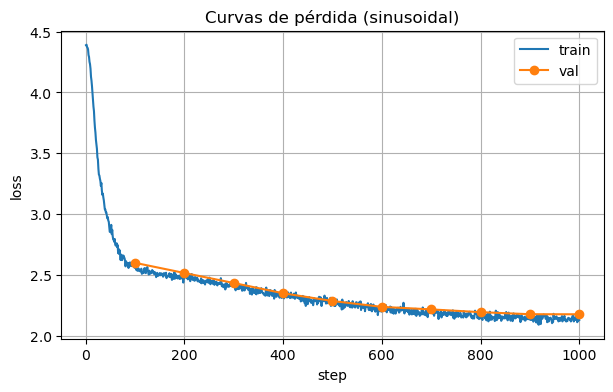

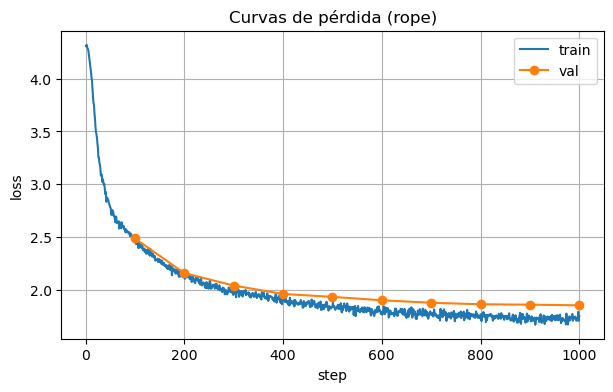

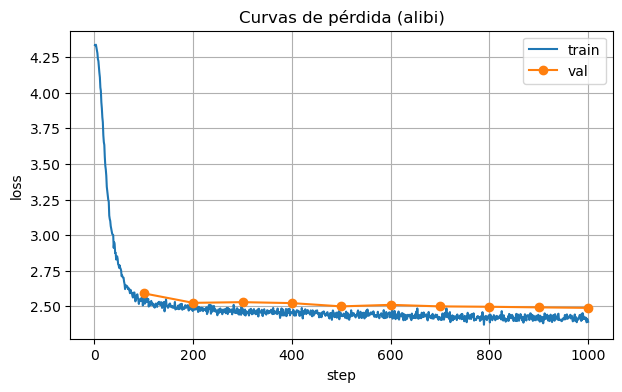

In [9]:

def load_curves(posenc_type: str):
    tag = posenc_type.lower()
    train_curve_path = f"outputs/train_curve_{tag}.csv"
    val_curve_path = f"outputs/val_curve_{tag}.csv"

    df_train = pd.read_csv(train_curve_path)
    df_val = pd.read_csv(val_curve_path)
    return df_train, df_val


for posenc_type in ["sinusoidal", "rope", "alibi"]:
    df_tr, df_val = load_curves(posenc_type)

    plt.figure(figsize=(7, 4))
    plt.plot(df_tr["step"], df_tr["train_loss"], label="train")
    plt.plot(df_val["step"], df_val["val_loss"], "o-", label="val")
    plt.title(f"Curvas de pérdida ({posenc_type})")
    plt.xlabel("step")
    plt.ylabel("loss")
    plt.grid(True)
    plt.legend()
    plt.show()


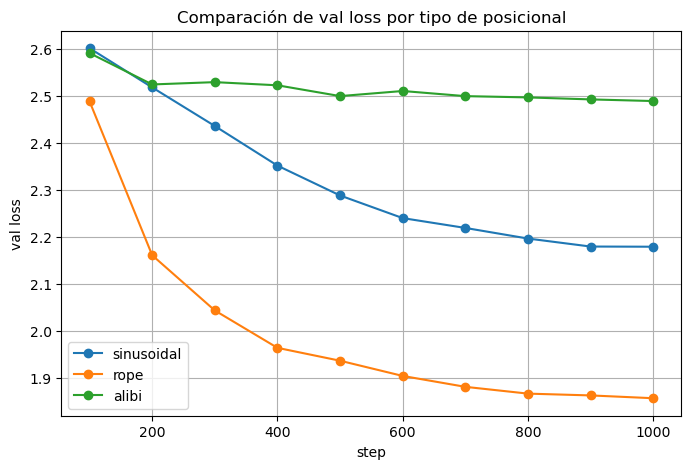

In [10]:

plt.figure(figsize=(8, 5))

for posenc_type in ["sinusoidal", "rope", "alibi"]:
    tag = posenc_type.lower()
    df_val = pd.read_csv(f"outputs/val_curve_{tag}.csv")
    plt.plot(df_val["step"], df_val["val_loss"], "o-", label=posenc_type)

plt.title("Comparación de val loss por tipo de posicional")
plt.xlabel("step")
plt.ylabel("val loss")
plt.grid(True)
plt.legend()
plt.show()
